# Earnings on Medium (code)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
/Users/conormcdonald/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/conormcdonald/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/conormcdonald/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be repre

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
/Users/conormcdonald/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/conormcdonald/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.389,0.206,0.016,0.791,0.003,0.002,5749.0,5298.0,5773.0,5585.0,1.0
b,0.020,0.001,0.017,0.022,0.000,0.000,6077.0,6077.0,6092.0,5587.0,1.0
error,1.323,0.137,1.075,1.573,0.002,0.001,5469.0,5469.0,5363.0,4415.0,1.0


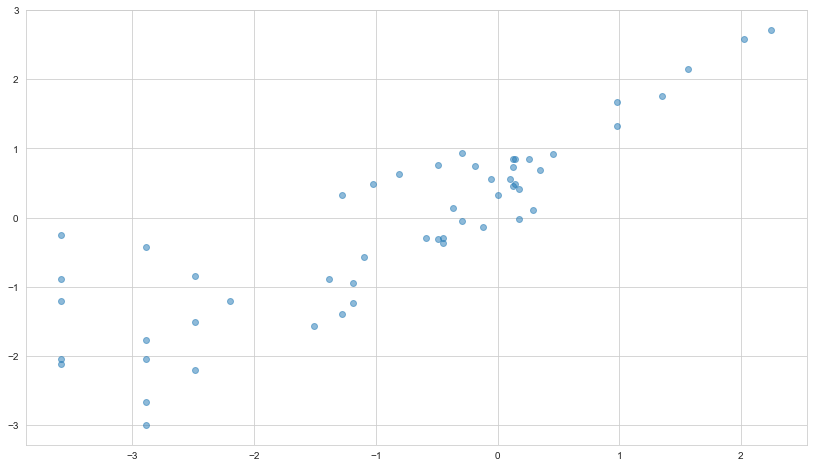

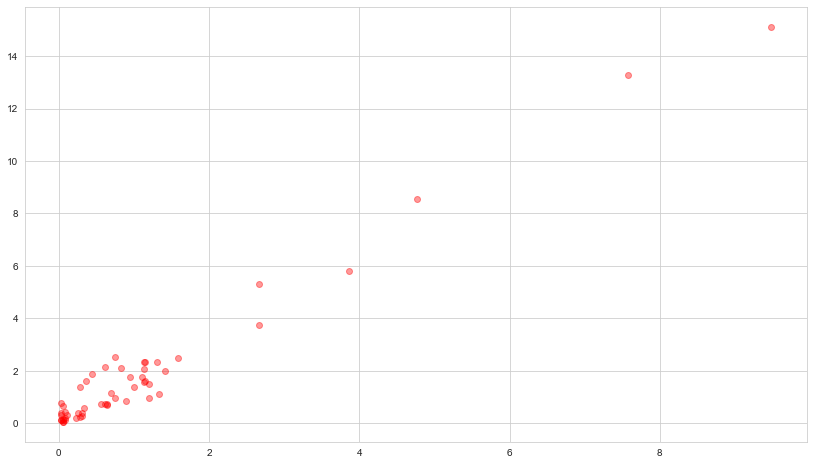

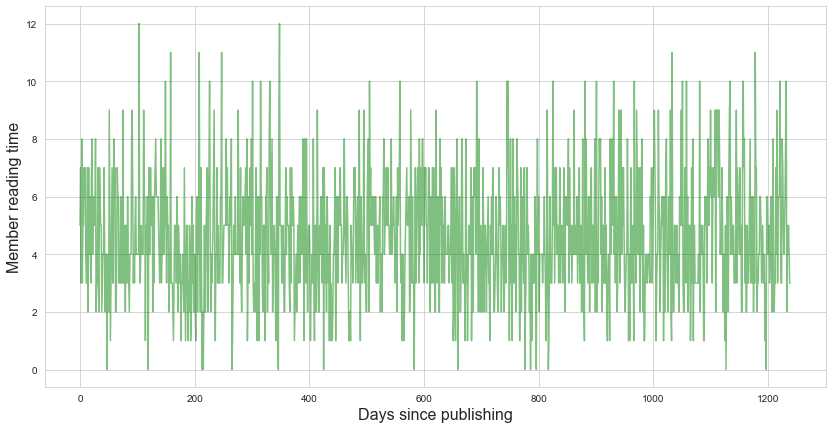

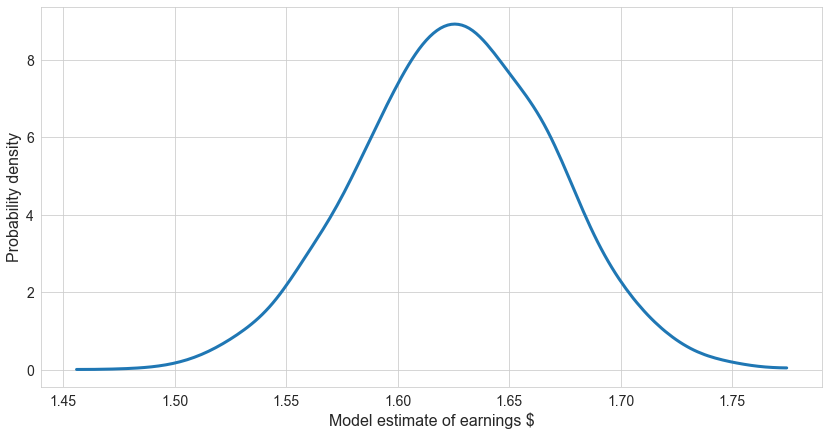

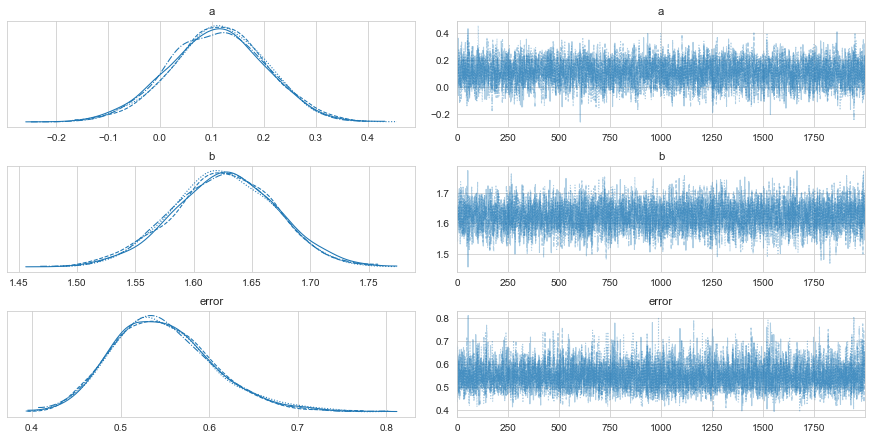

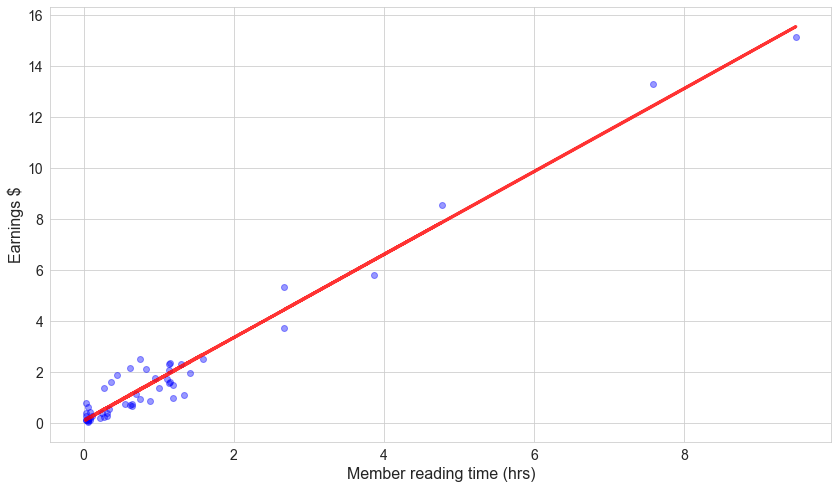

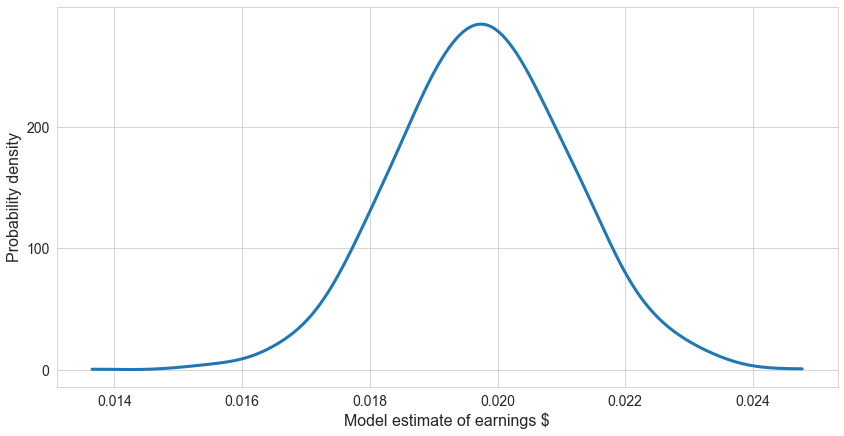

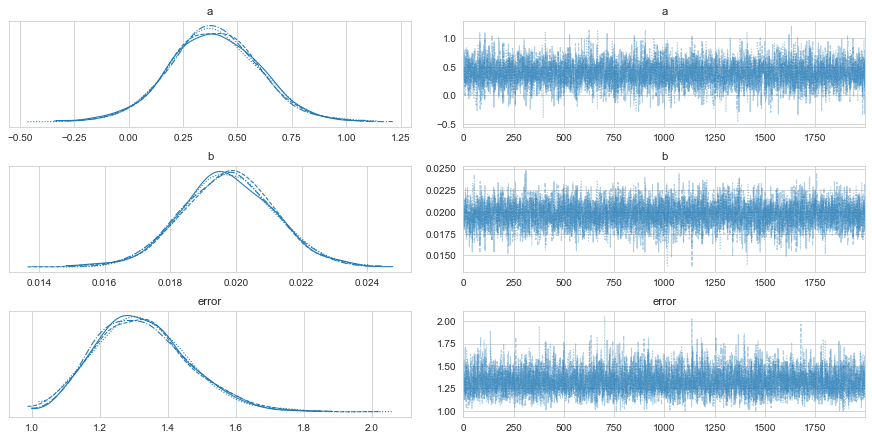

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pymc3 as pm
sns.set_style("whitegrid")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

df = pd.read_csv("/Users/conormcdonald/Desktop/medium_post_data.csv", skiprows=1).iloc[:, 1:-4]
df = df[~df.internal_views.isnull()]

h = df.member_reading_time.astype(str).str.split(".", expand=True)
h.loc[:, 0] = (h.loc[:, 0].astype(float) * 60)/60
h.loc[:, 1] = ("." + h.loc[:, 1]).astype(float)
h.loc[:, 1] = (h.loc[:, 1] * 100)/60
df["member_reading_time_adj"] = h.sum(1)

plt.figure(figsize=(14, 8))
plt.scatter(np.log(df.member_reading_time_adj), np.log(df.earnings), alpha=.5)

m = sm.OLS(endog=df.earnings, exog=sm.add_constant(df[["member_reading_time_adj"]])) 
fitted = m.fit()
fitted.summary()

plt.figure(figsize=(14, 8))
plt.scatter(df.member_reading_time_adj, df.earnings, alpha=.4, color="red")

pd.to_datetime("2021-04-20")-pd.to_datetime("2017-11-27")

plt.figure(figsize=(14, 7))
np.random.seed(123)
x = np.clip(sm.add_constant(np.random.poisson(lam=4.61, size=1240)), 0, np.Inf)
plt.plot(x[:, 1], c="green", alpha=.5)
plt.ylabel("Member reading time", fontsize=16)
plt.xlabel("Days since publishing", fontsize=16)

x[:, 1].sum()/60

fitted.predict(x).sum()

df["yhat"] = fitted.predict(sm.add_constant(df.member_reading_time_adj))

df.assign(error = lambda x: x.earnings-x.yhat).error.mean()

## Bayesian Model 

hours_model = pm.Model()
with hours_model:
    
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 1)
    error = pm.HalfCauchy("error", 3)
    
    yhat = a + b * df.member_reading_time_adj

    lik = pm.Normal("lik", yhat, error, observed=df.earnings)

with hours_model:
    trace = pm.sample(2000, chains=4)

plt.figure(figsize=(14, 7))
pm.plot_dist(trace["b"])
plt.xlabel("Model estimate of earnings $", fontsize=16)
plt.ylabel("Probability density", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

pm.traceplot(trace);

pm.summary(trace)

preds = pm.sample_posterior_predictive(trace, model=hours_model, samples=2000)

plt.figure(figsize=(14, 8))
plt.scatter(df.member_reading_time_adj, df.earnings, alpha=.4, color="blue")
plt.plot(df.member_reading_time_adj, pd.DataFrame(preds["lik"]).mean(), alpha=.8, color="red", linewidth=3)
plt.xlabel("Member reading time (hrs)", fontsize=16)
plt.ylabel("Earnings $", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

pm.trace_to_dataframe(trace)

views_model = pm.Model()
with views_model:
    
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 1)
    error = pm.HalfCauchy("error", 3)
    
    yhat = a + b * df.internal_views

    lik = pm.Normal("lik", yhat, error, observed=df.earnings)

with views_model:
    trace = pm.sample(2000, chains=4)

plt.figure(figsize=(14, 7))
pm.plot_dist(trace["b"])
plt.xlabel("Model estimate of earnings $", fontsize=16)
plt.ylabel("Probability density", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

pm.traceplot(trace);

pm.summary(trace)